In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.font_manager as fm
import platform

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### cleaned 데이터 SVM

In [3]:
df = pd.read_csv('../../data/processed/sleep_cycle_productivity_cleaned.csv')

In [4]:
# 순서형 변수 정의 및 변환
ordered_score = CategoricalDtype(categories=list(range(1, 11)), ordered=True)
df['Sleep Quality'] = df['Sleep Quality'].astype(ordered_score)
df['Productivity Score'] = df['Productivity Score'].astype(ordered_score)
df['Mood Score'] = df['Mood Score'].astype(ordered_score)
df['Stress Level'] = df['Stress Level'].astype(ordered_score)

df['Weekday'] = df['Weekday'].astype('category')
df['Gender'] = df['Gender'].astype('category')

df['Sleep_Quality_Binary'] = (df['Sleep Quality'] >= 5).astype(int)
y = df['Sleep_Quality_Binary']

X = df[['Age', 'Gender', 'Sleep Start Time', 'Sleep End Time',
        'Total Sleep Hours', 'Exercise (mins/day)',
        'Screen Time Before Bed (mins)', 'Work Hours (hrs/day)',
        'Productivity Score', 'Mood Score', 'Stress Level', 'Weekday']]

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
clf_cleaned = SVC(kernel="rbf", random_state=42)
clf_cleaned.fit(X_train_scaled, y_train)
y_pred_cleaned = clf_cleaned.predict(X_test_scaled)

print("=== Cleaned Data SVM ===")
print("Accuracy:", accuracy_score(y_test, y_pred_cleaned))
print("Classification Report:\n", classification_report(y_test, y_pred_cleaned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cleaned))

=== Cleaned Data SVM ===
Accuracy: 0.569
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.05      0.09       423
           1       0.58      0.95      0.72       577

    accuracy                           0.57      1000
   macro avg       0.50      0.50      0.40      1000
weighted avg       0.51      0.57      0.45      1000

Confusion Matrix:
 [[ 21 402]
 [ 29 548]]


### PCA+군집분석 SVM

In [7]:
df_pca = pd.read_csv("../../data/processed/3_pca_cluster_data.csv")

In [8]:
y_pca = df_pca["Sleep_Quality_Binary"]

X_pca = df_pca.drop(columns=["Sleep_Quality_Binary", "Cluster"])

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=5)

scaler = StandardScaler()
X_train_scaled_pca = scaler.fit_transform(X_train)
X_test_scaled_pca = scaler.transform(X_test)

In [9]:
clf_pca = SVC(kernel="rbf", random_state=42)
clf_pca.fit(X_train_scaled, y_train)
y_pred_pca = clf_pca.predict(X_test_scaled_pca)

print("=== SVM on PCA+Cluster Data ===")
print("Accuracy:", accuracy_score(y_test_pca, y_pred_pca))
print("Classification Report:\n", classification_report(y_test_pca, y_pred_pca))
print("Confusion Matrix:\n", confusion_matrix(y_test_pca, y_pred_pca))

=== SVM on PCA+Cluster Data ===
Accuracy: 0.608
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.07      0.13       400
           1       0.61      0.96      0.75       600

    accuracy                           0.61      1000
   macro avg       0.59      0.52      0.44      1000
weighted avg       0.60      0.61      0.50      1000

Confusion Matrix:
 [[ 29 371]
 [ 21 579]]


### cleaned와 PCA 버전 SVM 비교

In [10]:
def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

# 2. 각 모델의 결과 수집
metrics_cleaned = get_metrics(y_test, y_pred_cleaned)
metrics_pca = get_metrics(y_test, y_pred_pca)
metrics_pca_cluster = get_metrics(y_test_pca, y_pred_pca)  # 변수명 주의

results_df = pd.DataFrame([
    {"Model": "Cleaned", **metrics_cleaned},
    {"Model": "PCA", **metrics_pca},
    {"Model": "PCA+Cluster", **metrics_pca_cluster}
])

print("=== SVM 성능 비교 ===")
print(results_df)

=== SVM 성능 비교 ===
         Model  Accuracy  Precision   Recall  F1 Score
0      Cleaned     0.569   0.576842  0.94974  0.717747
1          PCA     0.569   0.576842  0.94974  0.717747
2  PCA+Cluster     0.608   0.609474  0.96500  0.747097


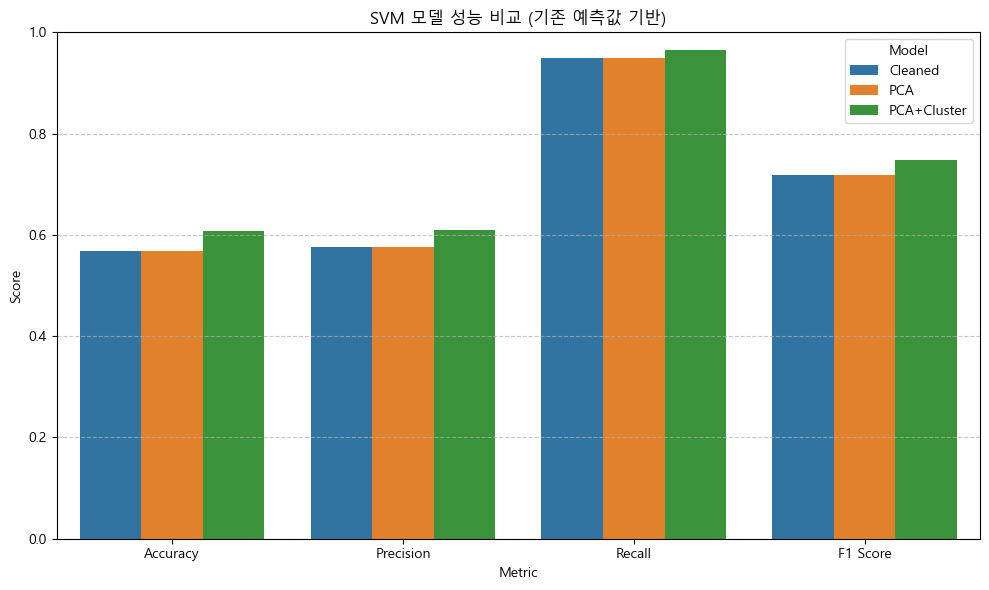

In [11]:
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="Metric", y="Score", hue="Model")
plt.title("SVM 모델 성능 비교 (기존 예측값 기반)")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

PCA+Cluster 모델이 전체적으로 더 많은 샘플을 정확히 분류.

정밀도 역시 PCA+Cluster > Cleaned = PCA

세 모델 모두 매우 높음 (0.95 이상) → 실제 양성을 잘 찾아냄. $\\$ 다만, 정밀도가 낮은 것을 보면, 과하게 양성으로 예측하는 경향이 있다는 의미.

### cleaned에 커널 실험

In [13]:
kernels = ["linear", "poly", "sigmoid"]

for kernel in kernels:
    clf = SVC(kernel=kernel, random_state=42)  # <- 여기에서 kernel 변수 사용
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    print(f"--- Kernel: {kernel} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print()

--- Kernel: linear ---
Accuracy: 0.577
F1 Score: 0.7317691819911224

--- Kernel: poly ---
Accuracy: 0.554
F1 Score: 0.6814285714285714

--- Kernel: sigmoid ---
Accuracy: 0.575
F1 Score: 0.7263361236316807

